# Introducción {.unnumbered}


Este documento analiza flujos de datos (_data streams_) utilizando el dataset [`Elec2`](https://riverml.xyz/latest/api/datasets/Elec2/), que contiene información sobre precios de electricidad en Nueva Gales del Sur, Australia. Este conjunto de datos es ideal para evaluar algoritmos de aprendizaje automático debido a su naturaleza temporal y compleja.

Se utiliza la biblioteca de Python [River](https://riverml.xyz) para implementar y evaluar algoritmos de clasificación, detección de concept drift y clustering.

El documento está organizado en cuatro secciones principales (asociadas a cada uno de los ejercicios propuestos) además de la introducción y presentación del conjunto de datos: [Técnica de Evaluación: _Holdout_](#holdout), [Técnica de Evaluación: _Prequential_](#prequential), [Detección de _Concept Drift_](#drift) y [Técnicas de _Clustering_](#clustering).

::: {.callout-note}

## Creación del Documento

El Jupyter Notebook ha sido convertido a un documento PDF utilizando [Quarto](https://quarto.org/). Algunas celdas, como las que contienen código para mostrar gráficos y ciertos resultados, se han ocultado para evitar redundancias y mantener el documento limpio.

Se puede consultar el Notebook original en el [repositorio de GitHub](https://github.com/javiervela/electricity-pricing-online-learning).
:::


En la siguiente celda, se importan las librerías necesarias. Para la gestión de datos se utiliza `pandas`, para la visualización `matplotlib` y `seaborn`, para operaciones matemáticas `numpy`, y para el aprendizaje automático _online_ se utiliza `river`.

La librería `river` es una biblioteca de aprendizaje automático en Python diseñada para trabajar con flujos de datos. Permite implementar algoritmos de aprendizaje automático que pueden adaptarse a datos que llegan de forma continua, lo que es ideal para el análisis de series temporales y la detección de cambios en los datos. Se utilizan los submódulos `river.datasets` para cargar el conjunto de datos, `river.cluster`, `river.neighbors` y `river.tree` para implementar los algoritmos de aprendizaje automático, `river.drift` para detectar _concept drift_ y `river.compose`, `river.metrics`, `river.preprocessing` y `river.utils` para crear la pipeline de preprocesamiento, entrenamiento y evaluación.


\newpage


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from river import cluster
from river import compose
from river import datasets
from river import drift
from river import metrics
from river import neighbors
from river import preprocessing
from river import tree
from river import utils

# Conjunto de Datos: `Elec2` {.unnumbered}


El dataset [`Elec2`](https://riverml.xyz/latest/api/datasets/Elec2/) contiene datos sobre el precio de la electricidad en Nueva Gales del Sur, Australia e incluye la transferencia de electricidad entre Nueva Gales del Sur y Victoria. El conjunto de datos presenta una tarea de clasificación binaria, donde el objetivo es predecir si el precio de la electricidad subirá o bajará en función de las características de consumo eléctrico.

El conjunto de datos contiene 45,312 instancias desde el 7 de mayo de 1996 hasta el 5 de diciembre de 1998. Cada instancia representa un período de 30 minutos, lo que equivale a 48 instancias por día.


In [ ]:
# | include: false
# | echo: false

dataset = datasets.Elec2()
print(dataset)

Electricity prices in New South Wales.

This is a binary classification task, where the goal is to predict if the price of electricity
will go up or down.

This data was collected from the Australian New South Wales Electricity Market. In this market,
prices are not fixed and are affected by demand and supply of the market. They are set every
five minutes. Electricity transfers to/from the neighboring state of Victoria were done to
alleviate fluctuations.

References
----------
[^1]: [SPLICE-2 Comparative Evaluation: Electricity Pricing](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.12.9405)
[^2]: [DataHub description](https://datahub.io/machine-learning/electricity#readme)

      Name  Elec2                                                      
      Task  Binary classification                                      
   Samples  45,312                                                     
  Features  8                                                          
    Sparse  False 

In [ ]:
# Cargar el conjunto de datos Elec2
dataset = datasets.Elec2()

La @tbl-elec2-dataset-head muestra las primeras 5 filas del conjunto de datos, con sus correspondientes valores para cada una de las columnas. Las características del conjunto de datos son las siguientes:

- `date`: Fecha de la medición.
- `day`: Día de la semana.
- `period`: Hora de la medición (1-48) en intervalos de media hora a lo largo de 24 horas.
- `nswprice`: Precio de la electricidad en Nueva Gales del Sur.
- `nswdemand`: Demanda de electricidad en Nueva Gales del Sur.
- `vicprice`: Precio de la electricidad en Victoria.
- `vicdemand`: Demanda de electricidad en Victoria.
- `transfer`: Transferencia programada de electricidad entre ambos estados.
- `target`: Variable objetivo que identifica el cambio de precio (UP = 1 o DOWN = 0) en Nueva Gales del Sur en relación con un promedio móvil de las últimas 24 horas.


La @tbl-elec2-dataset-info proporciona un resumen estadístico detallado de las columnas del conjunto de datos. Este análisis destaca que todas las variables numéricas están normalizadas entre 0 y 1, lo que facilita la comparación entre ellas y mejora el rendimiento de los algoritmos de aprendizaje automático. Además, esta normalización ayuda a mitigar el impacto de valores extremos o anomalías en los datos.

Por otro lado, la @tbl-elec2-dataset-target-counts muestra que la variable objetivo `target` está razonablemente balanceada, con un 42% de ejemplos positivos (`True`) y un 58% de ejemplos negativos (`False`). Este balance es crucial para evitar que los modelos de clasificación desarrollen un sesgo hacia una clase específica, lo que podría comprometer su capacidad de generalización.

Finalmente, la @fig-elec2-dataset-plots ilustra cómo evolucionan las variables relacionadas con el precio y la demanda a lo largo de la serie temporal. Se observa que la distribución de estas variables cambia con el tiempo, lo que sugiere la presencia de _concept drift_. Además, se destaca que la variable `vicprice` presenta valores muy bajos debido a la normalización, que incluye un valor extremadamente alto, posiblemente anómalo.


In [ ]:
# | include: false
# | echo: false

dataset = list(dataset)
dataset = [{**x, "target": y} for (x, y) in dataset]
dataset_df = pd.DataFrame(dataset)

In [ ]:
# | echo: false
# | label: tbl-elec2-dataset-head
# | tbl-cap: "Primeras 5 filas del dataset Elec2"

dataset_df.head(5)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,target
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,True
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,True
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,True
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,True
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,False


In [ ]:
# | echo: false
# | label: tbl-elec2-dataset-info
# | tbl-cap: "Información del dataset Elec2"

# Get statistical summary
summary = dataset_df.describe().loc[["count", "mean", "std", "min", "max"]]
summary.loc["unique"] = dataset_df.nunique()
summary = summary.transpose()

# Convert count and unique to integers and round other values
summary = summary.astype({"count": int, "unique": int})
for col in summary.columns:
    if col in ["count", "unique"]:
        continue
    summary[col] = summary[col].round(2)

summary

,count,mean,std,min,max,unique
date,45312,0.50,0.34,0.0,1.0,933
day,45312,4.00,2.00,1.0,7.0,7
period,45312,0.50,0.29,0.0,1.0,48
nswprice,45312,0.06,0.04,0.0,1.0,4089
nswdemand,45312,0.43,0.16,0.0,1.0,5266
vicprice,45312,0.00,0.01,0.0,1.0,3798
vicdemand,45312,0.42,0.12,0.0,1.0,2846
transfer,45312,0.50,0.15,0.0,1.0,1878


In [ ]:
# | echo: false
# | label: tbl-elec2-dataset-target-counts
# | tbl-cap: "Distribución de clases de la variable objetivo en el dataset Elec2"

target_counts = dataset_df["target"].value_counts(normalize=True).round(2).reset_index()
target_counts.columns = ["Value", "Proportion"]
target_counts = target_counts.style.format({"Proportion": "{:.1%}"})
target_counts

,Value,Proportion
0,False,58.0%
1,True,42.0%


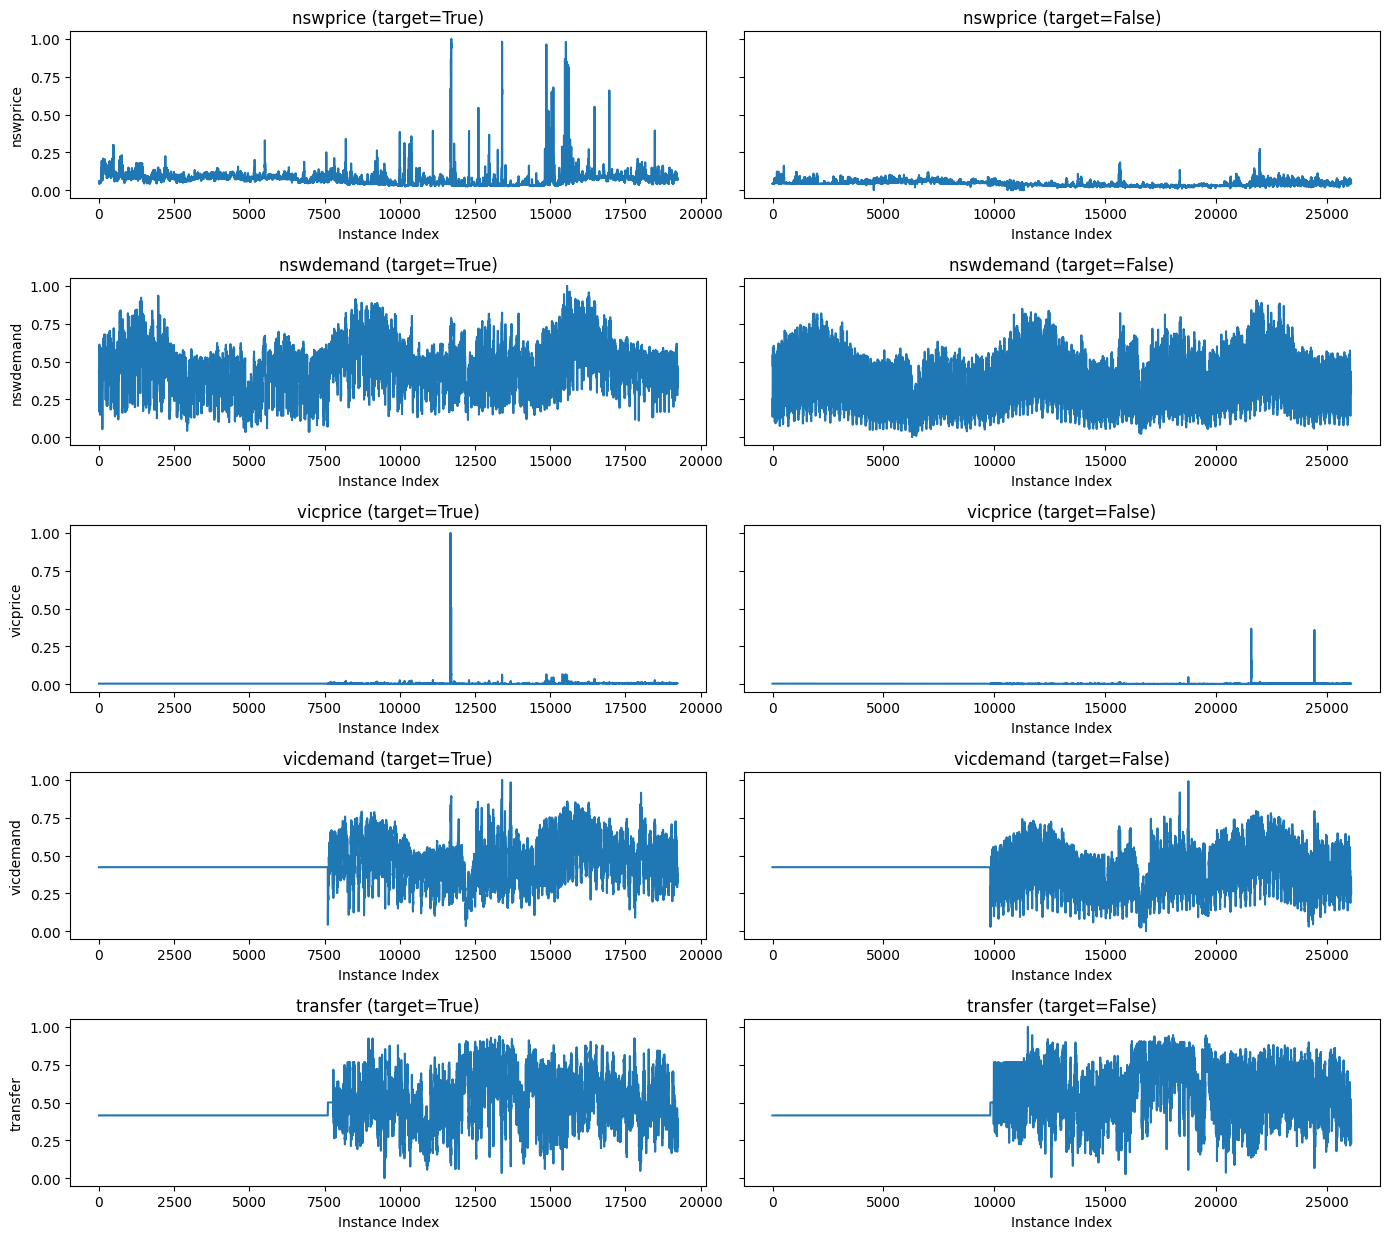

In [ ]:
# | echo: false
# | label: fig-elec2-dataset-plots
# | fig-cap: "Distribución de variables del dataset Elec2"

time_vars = {"date", "period", "day"}
plot_vars = [
    col for col in dataset_df.columns if col not in time_vars and col != "target"
]

n_vars = len(plot_vars)
fig, axes = plt.subplots(
    n_vars, 2, figsize=(14, 2.5 * n_vars), sharex=False, sharey="row"
)

for i, var in enumerate(plot_vars):
    for j, target_val in enumerate([True, False]):
        ax = axes[i, j]
        subset = dataset_df[dataset_df["target"] == target_val].reset_index(drop=True)

        sns.lineplot(data=subset, x=subset.index, y=var, ax=ax)
        ax.set_title(f"{var} (target={target_val})")
        ax.set_xlabel("Instance Index")
        ax.set_ylabel(var if j == 0 else "")

plt.tight_layout()
plt.show()

Dado que se ha observado que el conjunto de datos presenta _concept drift_, se ha realizado un análisis de el concepto de deriva en las variables individuales del conjunto de datos. Para ello, se ha utilizado la técnica Adaptive Windowing (ADWIN) para detectar cambios en la distribución de las variables a lo largo del tiempo. Esta técnica permite identificar si hay cambios significativos en la media de una secuencia de datos, lo que puede indicar la presencia de _concept drift_. En la @fig-elec2-dataset-drift se muestran los resultados de este análisis, que indica que las variables `nswprice`, `nswdemand` y `vicdemand` presentan cambios significativos en su distribución a lo largo del tiempo, lo que sugiere la presencia de _concept drift_ en estas variables. La variable `vicprice`, por otro lado, no muestra cambios significativos en su distribución mediante la técnica ADWIN. Esto se puede deber a que la variable `vicprice` tiene un rango de valores muy bajo debido a la normalización, lo que puede dificultar la detección de cambios significativos en su distribución.


In [ ]:
# Cargar el conjunto de datos
dataset = datasets.Elec2()
# Columnas a analizar
features = ["nswprice", "nswdemand", "vicprice", "vicdemand"]
# Inicializar el detector de cambio ADWIN para cada característica
adwins = {f: drift.ADWIN() for f in features}
# Inicializar listas para almacenar los puntos de cambio detectados y los valores
drift_points = {f: [] for f in features}
values = {f: [] for f in features}
time_steps = []

# Iterar sobre el conjunto de datos
for i, (x, _) in enumerate(dataset):
    time_steps.append(i)
    # Actualizar el detector de cambio para cada característica
    for f in features:
        val = x[f]
        values[f].append(val)
        adwin = adwins[f]
        adwin.update(val)
        # Verificar si se ha detectado un cambio
        if adwin.drift_detected:
            drift_points[f].append(i)

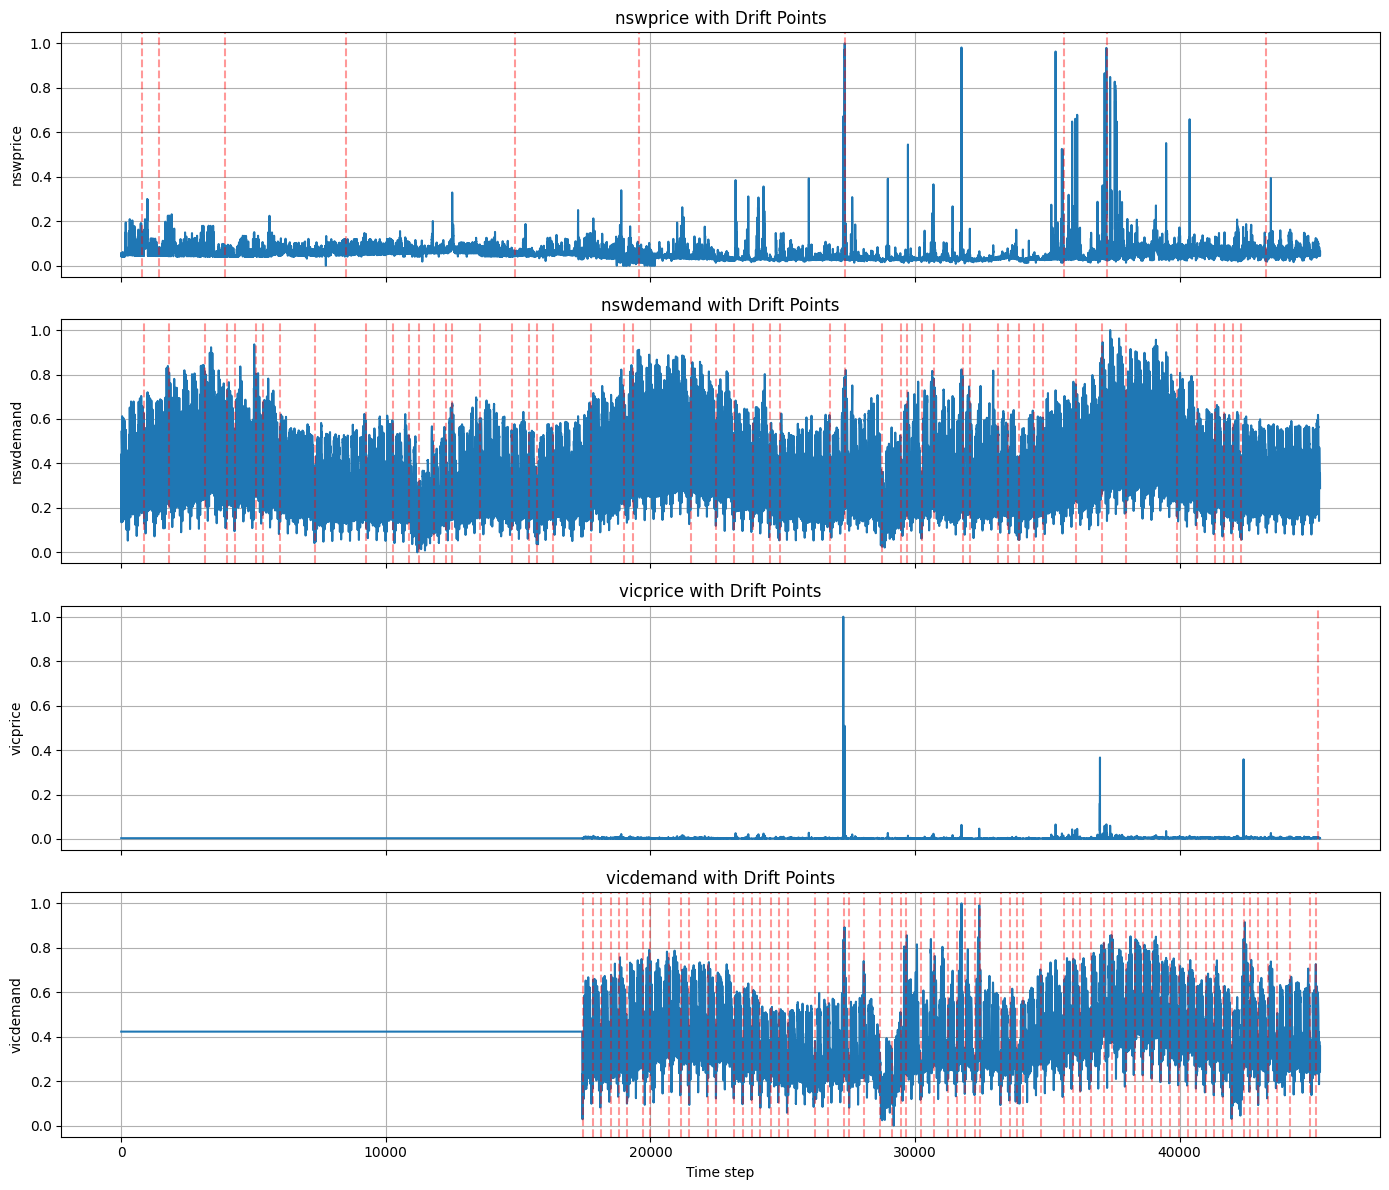

In [ ]:
# | echo: false
# | label: fig-elec2-dataset-drift
# | fig-cap: "Detección de Drift en algunas variables del dataset Elec2"

fig, axes = plt.subplots(len(features), 1, figsize=(14, 3 * len(features)), sharex=True)

for i, f in enumerate(features):
    ax = axes[i]
    ax.plot(time_steps, values[f], label=f"{f}")
    for drift_time in drift_points[f]:
        ax.axvline(x=drift_time, color="red", linestyle="--", alpha=0.4)
    ax.set_title(f"{f} with Drift Points")
    ax.set_ylabel(f)
    ax.grid(True)

axes[-1].set_xlabel("Time step")
plt.tight_layout()
plt.show()

\newpage


# Técnica de Evaluación: _Holdout_ {#holdout}


Con el objetivo de crear dos modelos de aprendizaje automático en línea para la clasificación del dataset Elec2 mediante el método de evaluación _holdout_, se ha desarrollado la función `train_holdout`. Esta función permite evaluar periódicamente un modelo dado, utilizando un conjunto de prueba dinámico, a partir de un flujo de datos continuo.

La evaluación _holdout_ se realiza con una proporción del 70% de las instancias para entrenamiento y el 30% restante para prueba. Los parámetros predeterminados de la función `train_holdout` están configurados para que, cada 1000 instancias procesadas, el modelo se entrene con las primeras 700 (70%) y se evalúe con las siguientes 300 (30%). En la @fig-holdout-train-test-splits se ilustran las particiones de entrenamiento y prueba realizadas en el conjunto de datos.


In [ ]:
def train_holdout(
    model, stream, metric_list, evaluation_interval=1000, test_window_size=300
):
    # Convertir el stream a un iterador
    stream_iter = iter(stream)
    steps = []
    results = []
    i = 1
    try:
        while True:
            x, y = next(stream_iter)
            # Aprender de una instancia
            model.learn_one(x, y)
            i += 1
            # Evaluar el modelo cada evaluation_interval
            if (i + test_window_size) % evaluation_interval == 0:
                # Obtener un conjunto de prueba de test_window_size instancias
                test_set = [next(stream_iter) for _ in range(test_window_size)]
                # Reiniciar las métricas
                for metric in metric_list:
                    metric.__init__()
                # Evaluar el modelo en el conjunto de prueba
                for x_test, y_test in test_set:
                    y_pred = model.predict_one(x_test)
                    # Actualizar las métricas
                    for metric in metric_list:
                        if y_pred is not None:
                            metric.update(y_test, y_pred)
                i += test_window_size
                steps.append(i)
                results.append([metric.get() for metric in metric_list])
    except StopIteration:
        pass
    return steps, results

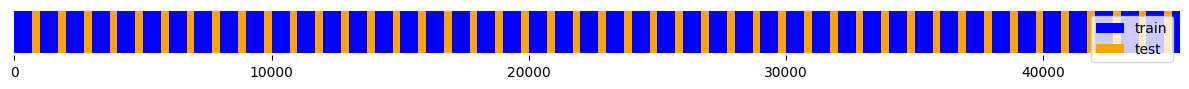

In [ ]:
# | echo: false
# | label: fig-holdout-train-test-splits
# | fig-cap: "Secciones del conjunto de datos utilizadas para entrenamiento y test"

datatset_list = list(datasets.Elec2())
dataset_length = len(datatset_list)

color_map = {"train": "blue", "test": "orange"}

steps_split = [("train" if (i % 1000) < 700 else "test") for i in range(dataset_length)]

segments = []
current = steps_split[0]
start = 0

for i, val in enumerate(steps_split):
    if val != current:
        segments.append((start, i - start, current))
        current = val
        start = i

segments.append((start, len(steps_split) - start, current))

fig, ax = plt.subplots(figsize=(12, 1))
for start, length, label in segments:
    ax.barh(
        0,
        width=length,
        left=start,
        color=color_map[label],
        edgecolor="none",
        label=(
            label
            if label
            not in [
                seg[2] for seg in segments[: segments.index((start, length, label))]
            ]
            else None
        ),
    )

ax.set_xlim(0, dataset_length)
ax.set_yticks([])
ax.set_xticks(range(0, dataset_length + 1, 10000))
ax.set_xticklabels(range(0, dataset_length + 1, 10000))
ax.set_frame_on(False)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

\newpage


In [ ]:
# | echo: false


def plot_evaluation_results(
    steps, results, metric_names, figure_title, drift_points=None
):
    transposed = list(zip(*results))
    num_metrics = len(transposed)

    # Use provided metric names or generate defaults
    if metric_names is None or len(metric_names) != num_metrics:
        metric_names = [f"Metric {i+1}" for i in range(num_metrics)]

    plt.figure(figsize=(8, 4))

    # Plot metrics
    for i, metric_values in enumerate(transposed):
        plt.plot(steps, metric_values, marker="o", label=metric_names[i])

    # Add drift points if provided
    if drift_points:
        for drift_time in drift_points:
            plt.axvline(x=drift_time, color="red", linestyle="--", alpha=0.4)

        # Add a label for drift in the legend
        plt.axvline(
            x=-1, color="red", linestyle="--", alpha=0.4, label="Drift detected"
        )

    plt.title(figure_title)
    plt.xlabel("Training steps")
    plt.ylabel("Metric values")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Hoeffding Tree con _Holdout_


El primer modelo utilizado es un clasificador basado en un Hoeffding Tree, un árbol de decisión diseñado para flujos de datos. Este modelo no almacena las instancias pasadas, sino que guarda únicamente la información necesaria para actualizar el árbol y realizar predicciones de manera eficiente. Los parámetros del modelo se han mantenido en sus valores predeterminados, aunque es probable que se puedan ajustar para mejorar el rendimiento del modelo.

El modelo se entrena con el conjunto de datos y se evalúa mediante la estrategia _Holdout_, utilizando las métricas de precisión (_accuracy_) y _F1-score_. Además, se incluye un preprocesamiento con `StandardScaler` para normalizar los datos y mejorar el rendimiento del modelo.

En la @fig-hoeffding-holdout-results se observa la evolución de ambas métricas en cada evaluación periódica (cada 1000 instancias procesadas). Los resultados muestran fluctuaciones significativas en las métricas, posiblemente debido al _concept drift_ presente en los datos. La precisión varía entre ~0.60 y ~0.95, mientras que el _F1-score_ oscila entre ~0.20 y ~0.95. Esto sugiere que el modelo enfrenta dificultades para adaptarse a los cambios en la distribución de los datos a lo largo del tiempo.


In [ ]:
datatset_stream = datasets.Elec2()
hoeffding_model = compose.Pipeline(
    preprocessing.StandardScaler(), tree.HoeffdingTreeClassifier()
)
metrics_list = [metrics.Accuracy(), metrics.F1(pos_val=True)]

hoeffding_holdout_steps, hoeffding_holdout_results = train_holdout(
    hoeffding_model, datatset_stream, metrics_list
)

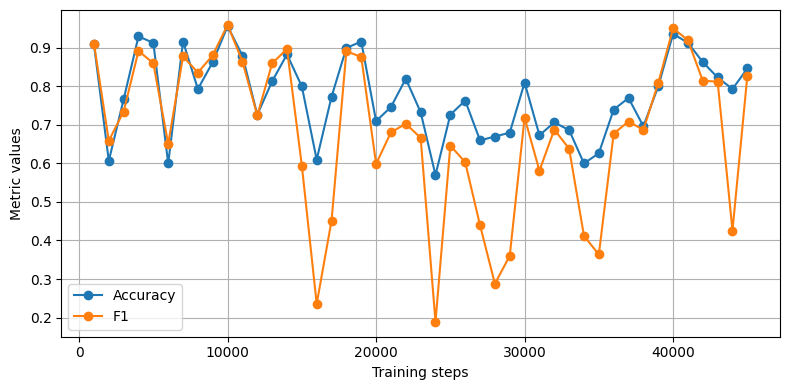

In [ ]:
# | echo: false
# | label: fig-hoeffding-holdout-results
# | fig-cap: "Resultados de la evaluación del modelo Hoeffding Tree utilizando el método de Holdout"

plot_evaluation_results(
    hoeffding_holdout_steps,
    hoeffding_holdout_results,
    metric_names=["Accuracy", "F1"],
    figure_title="",
)

\newpage


## KNN con _Holdout_


El segundo modelo entrenado es un clasificador KNN (_K-Nearest Neighbors_), basado en la premisa de que las instancias similares estarán cercanas en el espacio de características. Este modelo se entrena y evalúa utilizando las mismas técnicas y métricas que el modelo anterior. Los parámetros del modelo se han mantenido en sus valores predeterminados, aunque también es probable que se puedan ajustar para mejorar el rendimiento del modelo.

La @fig-knn-holdout-results muestra la evolución de las métricas de precisión (_accuracy_) y _F1-score_ en cada evaluación periódica. Al igual que el Hoeffding Tree, ambas métricas presentan fluctuaciones significativas. Los valores de precisión oscilan entre ~0.60 y ~0.90, mientras que el _F1-score_ varía entre ~0.30 y ~0.90. Esto indica que el modelo KNN también enfrenta dificultades para adaptarse a los cambios en la distribución de los datos.


In [ ]:
datatset_stream = datasets.Elec2()
neighbors_model = compose.Pipeline(
    preprocessing.StandardScaler(), neighbors.KNNClassifier()
)
metrics_list = [metrics.Accuracy(), metrics.F1(pos_val=True)]

neighbors_holdout_steps, neighbors_holdout_results = train_holdout(
    neighbors_model, datatset_stream, metrics_list
)

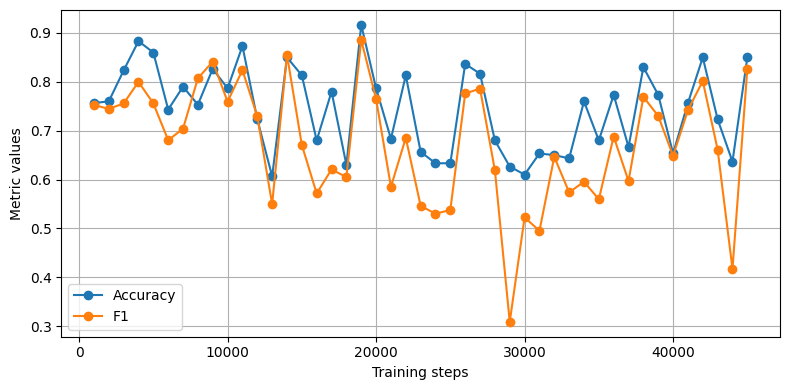

In [ ]:
# | echo: false
# | label: fig-knn-holdout-results
# | fig-cap: "Resultados de la evaluación del modelo KNN utilizando el método de Holdout"

plot_evaluation_results(
    neighbors_holdout_steps,
    neighbors_holdout_results,
    metric_names=["Accuracy", "F1"],
    figure_title="",
)

\newpage


## Comparación de Hoeffding Tree y KNN con _Holdout_


Para la comparación de ambos modelos, se han obtenido el último valor y el valor promedio de las métricas de precisión (_accuracy_) y _F1-score_ en la evaluación _holdout_. La @fig-holdout-comparison muestra los resultados obtenidos para ambos modelos. Ambos modelos presentan un rendimiento similar en la última fase del entrenamiento y evaluación. Sin embargo, el modelo basado en un Hoeffding Tree muestra un rendimiento ligeramente superior en el promedio de ambas métricas a lo largo de todo el proceso. Esto sugiere que, aunque ambos modelos son capaces de adaptarse a los cambios en la distribución de los datos, el Hoeffding Tree puede ser más efectivo en este contexto específico.


In [ ]:
# | echo: false


def compare_model_results(model_names, results_list, metric_names, evaluation_type):

    summary_data = {"Model": model_names}

    for i, metric_name in enumerate(metric_names):
        mean_values = []
        last_values = []

        for results in results_list:
            metric_values = [result[i] for result in results]
            mean_value = sum(metric_values) / len(metric_values)
            last_value = results[-1][i]

            mean_values.append(mean_value)
            last_values.append(last_value)

        summary_data[f"Mean {metric_name}"] = mean_values
        summary_data[f"Last {metric_name}"] = last_values

    results_table = pd.DataFrame(summary_data)

    styled_table = results_table.style.format(
        {col: "{:.2%}" for col in results_table.columns if col != "Model"}
    )
    # display(styled_table)

    num_models = len(model_names)
    num_metrics = len(metric_names)

    plt.figure(figsize=(8, 4))

    bar_width = 0.8 / (num_metrics * 2)
    index = np.arange(num_models)

    colors = [plt.cm.Set1(i) for i in range(num_metrics)]
    light_colors = [plt.cm.colors.to_rgba(color, alpha=0.6) for color in colors]

    for i, metric_name in enumerate(metric_names):
        offset = i * 2 * bar_width - (num_metrics - 1) * bar_width

        mean_pos = index + offset
        mean_values = summary_data[f"Mean {metric_name}"]
        plt.bar(
            mean_pos,
            mean_values,
            width=bar_width,
            label=f"Mean {metric_name}",
            color=colors[i],
        )

        last_pos = index + offset + bar_width
        last_values = summary_data[f"Last {metric_name}"]
        plt.bar(
            last_pos,
            last_values,
            width=bar_width,
            label=f"Last {metric_name}",
            color=light_colors[i],
        )

        for j, (mean_val, last_val) in enumerate(zip(mean_values, last_values)):
            plt.text(
                mean_pos[j],
                mean_val + 0.01,
                f"{mean_val:.2%}",
                ha="center",
                va="bottom",
                fontsize=8,
            )
            plt.text(
                last_pos[j],
                last_val + 0.01,
                f"{last_val:.2%}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.xlabel("Model")
    plt.ylabel("Score")
    # plt.title(
    #     f"Comparison of Model Performance ({evaluation_type.capitalize()} Evaluation)"
    # )
    plt.xticks(index, model_names)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

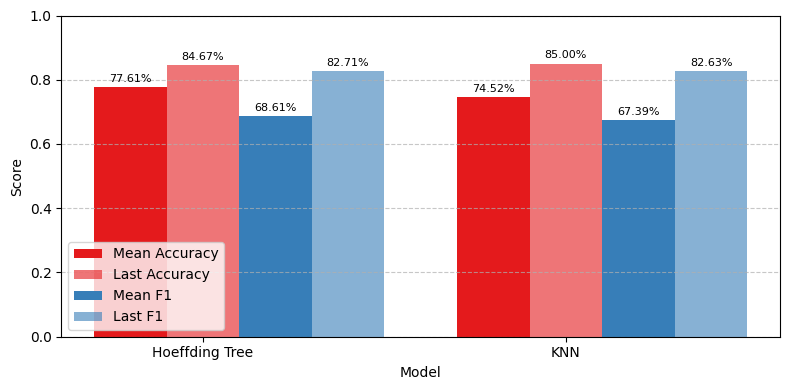

In [104]:
# | echo: false
# | label: fig-holdout-comparison
# | fig-cap: "Comparación de resultados de modelos utilizando el método de Holdout"

compare_model_results(
    model_names=["Hoeffding Tree", "KNN"],
    results_list=[hoeffding_holdout_results, neighbors_holdout_results],
    metric_names=["Accuracy", "F1"],
    evaluation_type="holdout",
)

\newpage


# Técnica de Evaluación: _Prequential_ {#prequential}


A continuación, se entrenan y evalúan los modelos utilizando la técnica de evaluación _prequential_. Esta técnica permite evaluar el rendimiento del modelo en tiempo real, utilizando cada instancia a medida que llega. Primero, se evalúa el modelo con la instancia actual y luego se utiliza esa misma instancia para actualizar el modelo. La función `train_prequential` implementa esta técnica, permitiendo evaluar el rendimiento del modelo en tiempo real.


In [ ]:
def train_prequential(model, stream, metric_list, evaluation_interval=1000):
    steps = []
    results = []
    # Iterar sobre el flujo de datos
    for i, (x, y) in enumerate(stream, start=1):
        # Realizar la predicción
        y_pred = model.predict_one(x)
        # Actualizar las métricas
        for metric in metric_list:
            if y_pred is not None:
                metric.update(y, y_pred)
        # Reportar métricas de evaluación cada evaluation_interval
        if i % evaluation_interval == 0:
            results.append([metric.get() for metric in metric_list])
            steps.append(i)
        # Aprender de la instancia
        model.learn_one(x, y)
    return steps, results

\newpage


## Hoeffding Tree con _Prequential_


El primer modelo utilizado es un clasificador basado en un Hoeffding Tree, que se entrena y evalúa utilizando la técnica _prequential_. Al igual que en el caso anterior, se incluye un preprocesamiento con `StandardScaler` para normalizar los datos y mejorar el rendimiento del modelo.

Dado que, en el caso del entrenamiento con la técnica _prequential_, el modelo se evalúa cada vez que llega una nueva instancia, las métricas de precisión (_accuracy_) y _F1-score_ se actualizan en cada iteración. Con el objetivo de que las métricas sean comparables con las obtenidas para el entrenamiento con _Holdout_, se utilizan métricas con una ventana de 1000 instancias. Esto significa que, cada 1000 instancias procesadas, se calcula el promedio de las métricas para evaluar el rendimiento del modelo en ese período.

La @fig-hoeffding-prequential-results muestra la evolución de ambas métricas en cada evaluación periódica (cada 1000 instancias procesadas). Los resultados también muestran fluctuaciones significativas en las métricas, aunque no tan marcadas como en el caso de los modelos entrenados con _Holdout_. La precisión varía entre ~0.70 y ~0.90, mientras que el _F1-score_ oscila entre ~0.50 y ~0.90.


In [ ]:
datatset_stream = datasets.Elec2()
hoeffding_model = compose.Pipeline(
    preprocessing.StandardScaler(), tree.HoeffdingTreeClassifier()
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

hoeffding_prequential_steps, hoeffding_prequential_results = train_prequential(
    hoeffding_model, datatset_stream, metrics_list
)

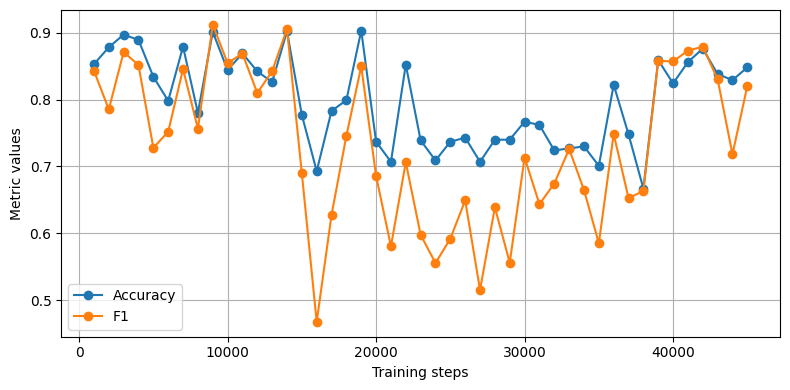

In [105]:
# | echo: false
# | label: fig-hoeffding-prequential-results
# | fig-cap: "Resultados de la evaluación del modelo Hoeffding Tree utilizando el método Prequential"


plot_evaluation_results(
    hoeffding_prequential_steps,
    hoeffding_prequential_results,
    metric_names=["Accuracy", "F1"],
    figure_title="",
)

\newpage


## KNN con _Prequential_


El modelo KNN también se entrena y evalúa utilizando la técnica _prequential_ con la misma configuración y métricas de evaluación que el modelo anterior. La @fig-knn-prequential-results muestra la evolución de las métricas de precisión (_accuracy_) y _F1-score_ en cada evaluación periódica. Los valores de precisión oscilan entre ~0.75 y ~0.95, mientras que el _F1-score_ varía entre ~0.70 y ~0.95.


In [ ]:
datatset_stream = datasets.Elec2()
neighbors_model = compose.Pipeline(
    preprocessing.StandardScaler(), neighbors.KNNClassifier()
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

neighbors_prequential_steps, neighbors_prequential_results = train_prequential(
    neighbors_model, datatset_stream, metrics_list
)

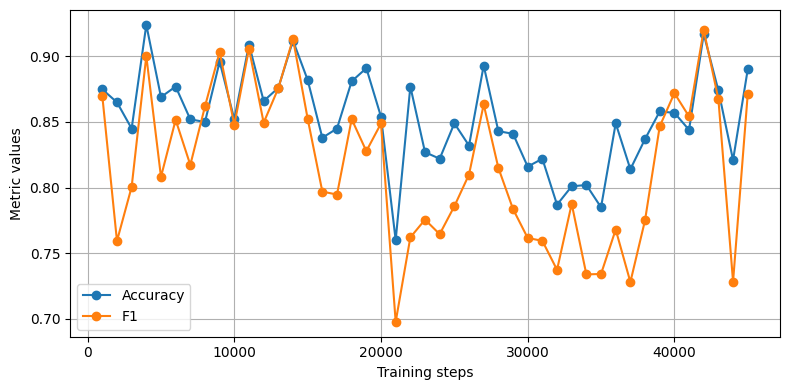

In [ ]:
# | echo: false
# | label: fig-knn-prequential-results
# | fig-cap: "Resultados de la evaluación del modelo KNN utilizando el método Prequential"

plot_evaluation_results(
    neighbors_prequential_steps,
    neighbors_prequential_results,
    metric_names=["Accuracy", "F1"],
    figure_title="",
)

\newpage


## Comparación de Hoeffding Tree y KNN con _Prequential_


La @fig-prequential-comparison muestra los resultados obtenidos para ambos modelos. En este caso, el modelo KNN presenta un rendimiento superior en ambas métricas, tanto en la última fase del entrenamiento como en el promedio de todas las fases. Esto sugiere que el modelo KNN es más efectivo en este contexto específico y puede adaptarse mejor a los cambios en la distribución de los datos a lo largo del tiempo.

<!-- Sin embargo, es importante tener en cuenta que el rendimiento de los modelos puede variar según la naturaleza de los datos y la configuración del modelo. Por lo tanto, es recomendable realizar una evaluación exhaustiva y considerar múltiples combinaciones de hiperparámetros y métricas de evaluación adicionales antes de tomar decisiones sobre el modelo a utilizar. -->


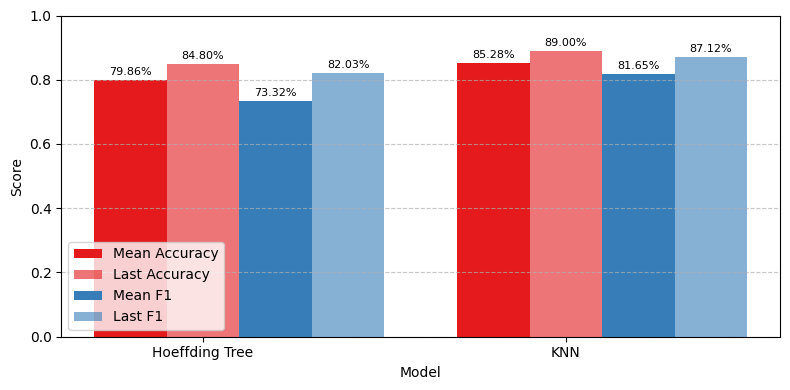

In [ ]:
# | echo: false
# | label: fig-prequential-comparison
# | fig-cap: "Comparación de resultados de modelos utilizando el método Prequential"

compare_model_results(
    model_names=["Hoeffding Tree", "KNN"],
    results_list=[hoeffding_prequential_results, neighbors_prequential_results],
    metric_names=["Accuracy", "F1"],
    evaluation_type="prequential",
)

\newpage


# Detección de _Concept Drift_ {#drift}


Como se ha observado en el análisis del conjunto de datos, el dataset `Elec2` presenta _concept drift_. Además, se ha mencionado que el modelo Hoeffding Tree y el modelo KNN presentan fluctuaciones significativas en las métricas de evaluación, lo que sugiere que ambos modelos enfrentan dificultades para adaptarse a los cambios en la distribución de los datos a lo largo del tiempo.

La función `train_prequential_drift` implementa un enfoque de evaluación _prequential_ con detección de _concept drift_ utilizando el algoritmo ADWIN. Durante el proceso, el modelo se entrena y evalúa iterativamente sobre un flujo de datos continuo. En cada iteración, se realiza una predicción con el modelo actual y se actualizan las métricas de evaluación proporcionadas. Simultáneamente, se utiliza ADWIN para detectar cambios significativos en la distribución de los datos, basándose en los errores de predicción. Si se detecta un _drift_, el detector se reinicia y el modelo se restablece a su estado original para adaptarse a la nueva distribución de los datos.

In [117]:
def train_prequential_drift(model, stream, metric_list, evaluation_interval=1000):
    steps = []
    results = []
    # Inicializar el detector de drift
    drift_detector = drift.ADWIN()
    drift_points = []
    # Guardar el modelo original para reiniciarlo
    original_model = model.clone()
    # Iterar sobre el flujo de datos
    for i, (x, y) in enumerate(stream, start=1):
        # Realizar la predicción
        y_pred = model.predict_one(x)
        # Actualizar las métricas
        for metric in metric_list:
            if y_pred is not None:
                metric.update(y, y_pred)
        # Detectar drift
        if y_pred is not None:
            error = 0 if y == y_pred else 1
            drift_detector.update(error)
            if drift_detector.drift_detected:
                drift_points.append(i)
                # Reiniciar el detector de drift
                drift_detector = drift.ADWIN()
                # Reiniciar el modelo
                model = original_model.clone()
        # Reportar métricas de evaluación cada evaluation_interval
        if i % evaluation_interval == 0:
            results.append([metric.get() for metric in metric_list])
            steps.append(i)
        # Aprender de la instancia
        model.learn_one(x, y)
    return steps, results, drift_points

\newpage


## Hoeffding Tree con Detección de _Concept Drift_


Se ha entrenado un modelo Hoeffding Tree con detección de _concept drift_ utilizando la función `train_prequential_drift`. Se utiliza el mismo preprocesado y métricas de evaluación que en la sección anterior. La @fig-hoeffding-prequential-drift-results muestra la evolución de las métricas de precisión y _F1-score_ en cada evaluación periódica. Los resultados muestran que el modelo Hoeffding Tree con detección de _concept drift_ presenta un rendimiento más estable en comparación con el modelo sin detección de _drift_. La precisión varía entre ~0.70 y ~0.90, mientras que el _F1-score_ oscila entre ~0.55 y ~0.90. Esto sugiere que la detección de _concept drift_ permite al modelo adaptarse mejor a los cambios en la distribución de los datos a lo largo del tiempo.

En cuanto a la detección de _concept drift_, la figura resalta los momentos en los que se detectó un cambio significativo en la distribución de los datos. Estos momentos se indican con líneas verticales en la gráfica, lo que permite observar cómo el modelo se adapta a los cambios en la distribución de los datos a lo largo del tiempo. En el caso del Hoeffding Tree, se detectaron muchos cambios, lo que sugiere que el modelo es muy sensible a los cambios en la distribución de los datos. Los cambios detectados son tan abundantes que no permiten visualizar realmente los cambios en las métricas al reiniciar el modelo.

In [118]:
datatset_stream = datasets.Elec2()
hoeffding_model = compose.Pipeline(
    preprocessing.StandardScaler(), tree.HoeffdingTreeClassifier()
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

(
    hoeffding_prequential_drift_steps,
    hoeffding_prequential_drift_results,
    hoeffding_drift_points,
) = train_prequential_drift(hoeffding_model, datatset_stream, metrics_list)

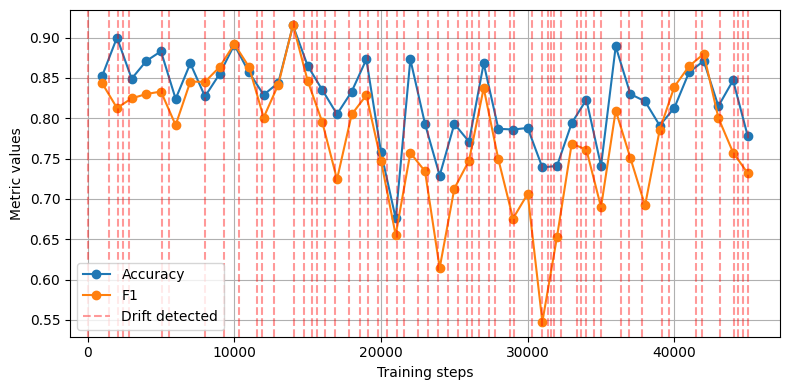

In [ ]:
# | echo: false
# | label: fig-hoeffding-prequential-drift-results
# | fig-cap: "Resultados de la evaluación del modelo Hoeffding Tree utilizando el método Prequential con detección de Drift"

plot_evaluation_results(
    hoeffding_prequential_drift_steps,
    hoeffding_prequential_drift_results,
    metric_names=["Accuracy", "F1"],
    figure_title="",
    drift_points=hoeffding_drift_points,
)

\newpage


## KNN con Detección de _Concept Drift_


El modelo KNN también se entrena y evalúa utilizando la función `train_prequential_drift` con detección de _concept drift_. La @fig-knn-prequential-drift-results muestra la evolución de las métricas de precisión y _F1-score_ en cada evaluación periódica. Los resultados muestran que el modelo KNN con detección de _concept drift_ presenta un rendimiento significativamente más estable en comparación con el modelo sin detección de _drift_. La precisión varía entre ~0.80 y ~0.95, mientras que el _F1-score_ oscila entre ~0.75 y ~0.95.

La detección de _concept drift_ en el modelo KNN también muestra momentos en los que se detectó un cambio significativo en la distribución de los datos. En el caso del KNN, se detectaron menos cambios que en el caso del Hoeffding Tree, lo que sugiere que el modelo es menos sensible a los cambios en la distribución de los datos. Además, tras los cambios marcados por las líneas verticales, se observa un cambio significativo en la tendencia de las métricas, lo que indica que el cambio en la distribución de los datos ha afectado al rendimiento del modelo.

In [120]:
datatset_stream = datasets.Elec2()
neighbors_model = compose.Pipeline(
    preprocessing.StandardScaler(), neighbors.KNNClassifier()
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

neighbors_prequential_steps, neighbors_prequential_results, neighbors_drift_points = (
    train_prequential_drift(neighbors_model, datatset_stream, metrics_list)
)

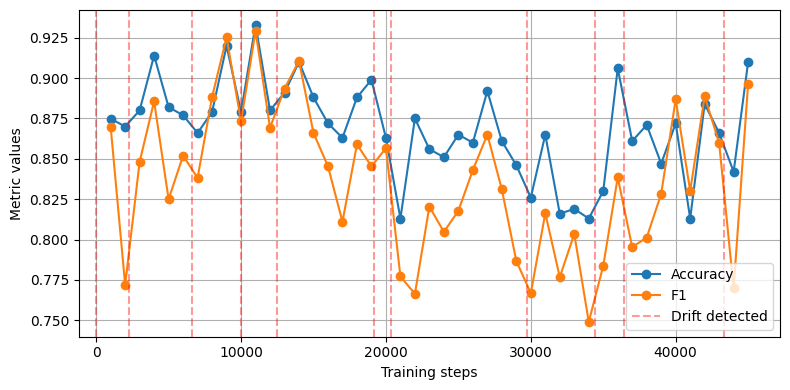

In [ ]:
# | echo: false
# | label: fig-knn-prequential-drift-results
# | fig-cap: "Resultados de la evaluación del modelo KNN utilizando el método Prequential con detección de Drift"

plot_evaluation_results(
    neighbors_prequential_steps,
    neighbors_prequential_results,
    metric_names=["Accuracy", "F1"],
    figure_title="",
    drift_points=neighbors_drift_points,
)

\newpage

## Comparación de Hoeffding Tree y KNN con Detección de _Concept Drift_

La @fig-prequential-drift-comparison muestra los resultados obtenidos para ambos modelos. En este caso, el modelo KNN presenta un rendimiento muy superior en ambas métricas, tanto en la última fase del entrenamiento como en el promedio de todas las fases. Esto sugiere que el modelo KNN es más efectivo en este contexto específico y puede adaptarse mejor a los cambios en la distribución de los datos a lo largo del tiempo. Además, se ha visto como el modelo KNN, detectaba menos cambios en la distribución de sus errores que el modelo Hoeffding Tree, lo que sugiere que el modelo KNN es menos sensible a los cambios en la distribución de los datos. Esto puede ser una ventaja en algunos casos, ya que un modelo menos sensible a los cambios puede ser más robusto y menos propenso a sobreajustarse a los datos.

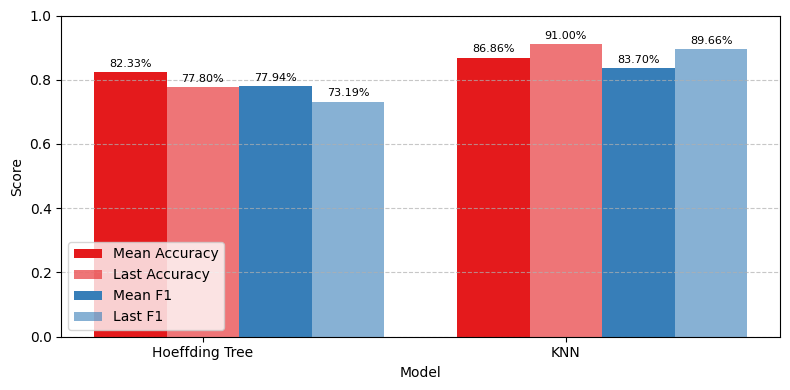

In [ ]:
# | echo: false
# | label: fig-prequential-drift-comparison
# | fig-cap: "Comparación de resultados de modelos utilizando el método Prequential con detección de Drift"

compare_model_results(
    model_names=["Hoeffding Tree", "KNN"],
    results_list=[
        hoeffding_prequential_drift_results,
        neighbors_prequential_results,
    ],
    metric_names=["Accuracy", "F1"],
    evaluation_type="prequential",
)

\newpage

# Técnicas de *Clustering* {#clustering}

Por último, se han implementado dos técnicas de _clustering_ para analizar el conjunto de datos `Elec2`. Estas técnicas permiten agrupar las instancias en función de sus características, lo que puede ayudar a identificar patrones y tendencias en los datos. Las técnicas de _clustering_ utilizadas son CluStream y DenStream, ambas implementadas en el módulo `river.cluster`. Para el entrenamiento y evaluación de los modelos de _clustering_, se ha utilizado la función `train_clustering` con la técnica *Prequential*, que permite evaluar el rendimiento del modelo en tiempo real, utilizando cada instancia a medida que llega.

In [ ]:
def train_clustering(model, stream, metrics_list, evaluation_interval=1000):
    steps = []
    results = []
    # Iterar sobre el flujo de datos
    for i, (x, y) in enumerate(stream, start=1):
        # Realizar la predicción
        y_pred = model.predict_one(x)
        # Actualizar las métricas
        for metric in metrics_list:
            if len(model.centers) > 1 and y_pred >= 0:
                metric.update(x, y_pred, model.centers)
        # Reportar métricas de evaluación cada evaluation_interval
        if i % evaluation_interval == 0:
            results.append([metric.get() for metric in metrics_list])
            steps.append(i)
        # Aprender de la instancia
        model.learn_one(x)
    return steps, results

\newpage

## Clustering con CluStream

El primer modelo de *clustering* utilizado es CluStream, un algoritmo de *clustering* diseñado para trabajar con flujos de datos. Por defecto, la implementación de CluStream de river utiliza un número de clusters de 5. Se ha mantenido este número de clusters para el modelo CluStream, aunque se podría ajustar en función de la naturaleza de los datos y los objetivos del análisis. El resto de parámetros del modelo se han mantenido en sus valores predeterminados.

Para evaluar el rendimiento del modelo de *clustering* se utiliza la métrica de Silhouette, que mide la calidad del agrupamiento. La métrica de Silhouette varía entre -1 y 1, donde un valor cercano a 1 indica que las instancias están bien agrupadas y separadas de otros grupos, mientras que un valor cercano a -1 indica que las instancias están mal agrupadas. Al igual que los modelos anteriores, se reporta su rendimiento cada 1000 instancias procesadas.

La @fig-clustream-results muestra la evolución de la métrica de Silhouette en cada evaluación periódica. Los resultados muestran que el modelo CluStream presenta un rendimiento estable, donde en las primeras 10000 iteraciones rápidamente baja a por debajo de 0.275 y se estabiliza en torno a 0.29, donde se mantiene con una tendencia ascendente hasta llegar a 0.31 al final del entrenamiento. Esto sugiere que el modelo CluStream es capaz de adaptarse a los cambios en la distribución de los datos a lo largo del tiempo y mejorar su rendimiento a medida que se procesan más instancias.

In [73]:
datatset_stream = datasets.Elec2()
clustream_model = cluster.CluStream()
metrics_list = [metrics.Silhouette()]

clustream_steps, clustream_results = train_clustering(
    clustream_model, datatset_stream, metrics_list
)

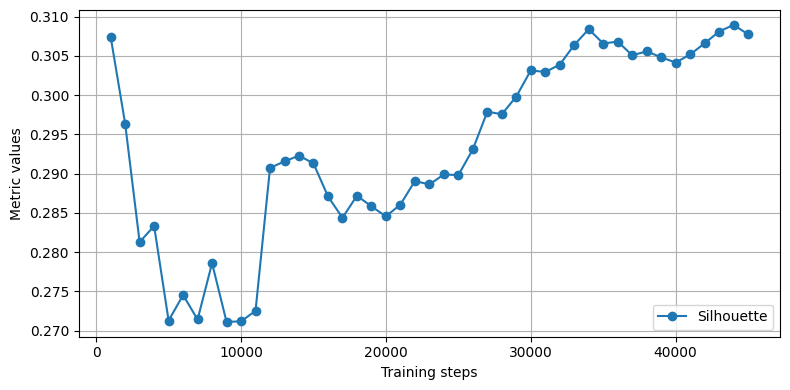

In [ ]:
# | echo: false
# | label: fig-clustream-results
# | fig-cap: "Resultados de la evaluación del modelo CluStream"

plot_evaluation_results(
    clustream_steps,
    clustream_results,
    metric_names=["Silhouette"],
    figure_title="",
)

\newpage

## Clustering con DenStream

El segundo modelo de *clustering* utilizado es DenStream, otro algoritmo de *clustering* diseñado para trabajar con flujos de datos. El número de clusters generados por DenStream es variable y depende de la naturaleza de los datos y los parámetros del modelo. En este caso, se han mantenido los parámetros predeterminados del modelo. Al igual que en el caso anterior, se utiliza la métrica de Silhouette para evaluar el rendimiento del modelo de *clustering*.

La @fig-denstream-results muestra la evolución de la métrica de Silhouette en cada evaluación periódica. Los resultados muestran que el modelo DenStream presenta un rendimiento más estable frente a CluStream, donde en las primeras 10000 iteraciones baja a por debajo de 0.32 e inmediatamente vuelve a subir con una tendencia ascendente hasta llegar a 0.36 al final del entrenamiento.

In [94]:
datatset_stream = datasets.Elec2()
denstream_model = cluster.DenStream()
metrics_list = [metrics.Silhouette()]

denstream_steps, denstream_results = train_clustering(
    denstream_model, datatset_stream, metrics_list
)

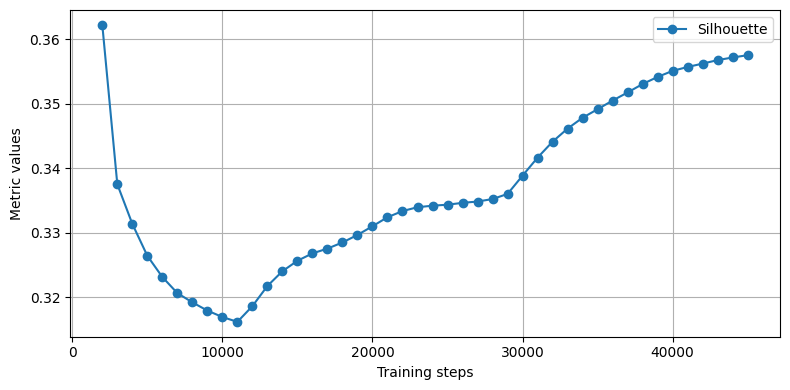

In [ ]:
# | echo: false
# | label: fig-denstream-results
# | fig-cap: "Resultados de la evaluación del modelo DenStream"

plot_evaluation_results(
    denstream_steps,
    denstream_results,
    metric_names=["Silhouette"],
    figure_title="",
)

\newpage

## Comparación de Clustering con CluStream y DenStream

La @fig-clustering-comparison muestra los resultados obtenidos para ambos modelos. En este caso, el modelo DenStream presenta un rendimiento superior en la métrica de Silhouette, lo que sugiere que el modelo DenStream es más efectivo en este contexto específico y puede adaptarse mejor a los cambios en la distribución de los datos a lo largo del tiempo. Además, se ha visto como el modelo DenStream, sufría menos fluctuaciones en su rendimiento que el modelo CluStream, lo que sugiere que el modelo DenStream es menos sensible a los cambios en la distribución de los datos.

In [ ]:
# | include: false
# | echo: false

denstream_results_trimmed = denstream_results[1:]

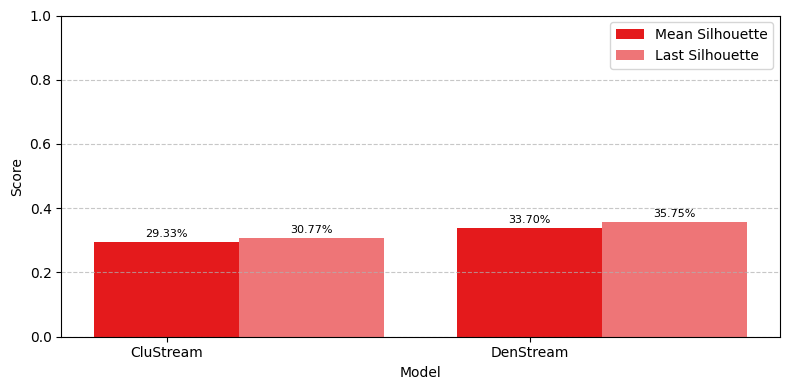

In [ ]:
# | echo: false
# | label: fig-clustering-comparison
# | fig-cap: "Comparación de resultados de modelos de clustering"

compare_model_results(
    model_names=["CluStream", "DenStream"],
    results_list=[clustream_results, denstream_results_trimmed],
    metric_names=["Silhouette"],
    evaluation_type="clustering",
)